In [1]:
import camera as cam
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Vision System Implementation Report

This report outlines the key implementation choices made for the vision component of a robot project. The primary tasks of the vision system include detection of various colored objects – such as green goals, black obstacles, blue circles, and red shapes – and the extraction of spatial information necessary for navigation and interaction within the environment. These tasks are achieved through color-based image segmentation and geometric transformations.

## Image preprocessing 

### Color Space Conversion to HSV

A fundamental aspect of the vision system's implementation is the decision to employ the Hue, Saturation, and Value (HSV) color space over the standard Blue, Green, and Red (BGR) color space. The HSV color space separates image luminance (intensity of light), from color information, which resides in the hue and saturation components. This separation is beneficial because it reduces the system's sensitivity to variation in lighting conditions, thus affording more robust color detection. The use of HSV is particularly advantageous in differentiating between colors that have similar brightness levels but different tones, which is common in real-world environments.

At first we did some tests of the image we created for the map as follows : 

In [5]:
# Load the image
image_numerical = cv2.imread('maps/numerical_map.jpeg')
image_real      = cv2.imread('maps/real_map.jpeg')

OpenCV employs the BGR image format, meaning that when utilizing cv2.imread(), images are automatically interpreted in the BGR format. [20]

In [6]:
# Inverse red and blue
image_numerical = cv2.cvtColor(image_numerical, cv2.COLOR_BGR2RGB)
image_real      = cv2.cvtColor(image_real, cv2.COLOR_BGR2RGB)

# Convert to HSV
hsv_numerical = cv2.cvtColor(image_numerical, cv2.COLOR_RGB2HSV)
hsv_real      = cv2.cvtColor(image_real, cv2.COLOR_RGB2HSV)

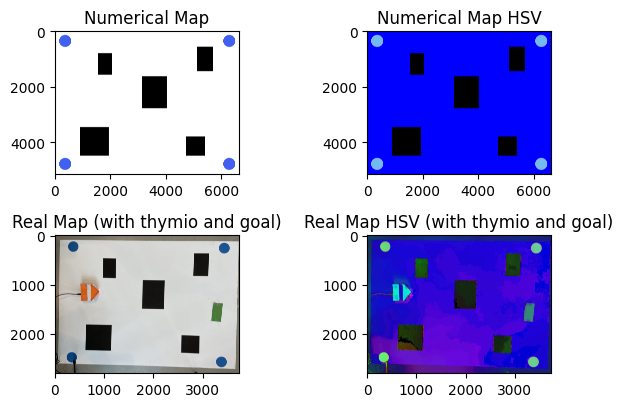

In [7]:
plt.subplot(2,2,1)
plt.imshow(image_numerical)
plt.title('Numerical Map')

plt.subplot(2,2,2)
plt.imshow(hsv_numerical)
plt.title('Numerical Map HSV')

plt.subplot(2,2,3)
plt.imshow(image_real)
plt.title('Real Map (with thymio and goal)')

plt.subplot(2,2,4)
plt.imshow(hsv_real)
plt.title('Real Map HSV (with thymio and goal)')

plt.subplots_adjust(hspace=0.2)  # Add space between the two lines
plt.subplots_adjust(wspace=0.7)  # Add space between the two columns

plt.show()

### Filtering Techniques

Bilateral filtering is employed on the HSV image before segmentation to reduce noise while preserving edge details. Unlike simple Gaussian filters, bilateral filtering considers both spatial proximity as well as color similarity, which avoids blurring across color edges. This technique was chosen to improve the accuracy of contour detection, as precise edge localization is critical for geometric analysis and object differentiation.

As well as the image, the function takes $\sigma_{Color}$ and $\sigma_{Space}$ as arguments :

* $\sigma_{Color}$ : A value in the color space, which decides the filter strength. A larger value means colors farther apart are considered as similar.
* $\sigma_{Space}$ : A value in the coordinate space, which determines the filter sigma in the position domain. A larger value means farther pixels will influence each other as long as their colors are close enough.

Values of $\sigma_{Color}$ and $\sigma_{Space}$ have been found empirically during the vision debuging phase.

In [ ]:
# Apply bilateral filter to hsv image
hsv_real_filtered = cv2.bilateralFilter(hsv_real, 9, 80, 80)

### Adaptive Thresholding for Color Segmentation

After applying the filter, an adaptive thresholding approach is implemented to define ranges for each color of interest. This method is chosen to accommodate the variability in color appearance caused by factors such as shadows, reflections, and inconsistent lighting. By dynamically setting the lower and upper bounds of color ranges with specified thresholds for HSV components, more consistent detection is reached across different conditions.

Fun fact: we had issues with red detection so we changed it with orange and it worked well better. From this moment, orange became the new red.

In [ ]:
# Define color ranges for every colored shape
black_lower, black_upper = cam.black_range_hsv(cam.BRIGHTNESS_THRESHOLD-1)
green_lower, green_upper = cam.hsv_range(cam.GREEN_BGR, cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)
red_lower  , red_upper   = cam.hsv_range(cam.RED_BGR,   cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)
blue_lower , blue_upper  = cam.hsv_range(cam.BLUE_BGR,  cam.COLOR_THRESHOLD, cam.SATURATION_THRESHOLD, cam.BRIGHTNESS_THRESHOLD)

# Create masks for every color
black_mask  = cv2.inRange(hsv_real_filtered, black_lower, black_upper)
green_mask  = cv2.inRange(hsv_real_filtered, green_lower, green_upper)
red_mask    = cv2.inRange(hsv_real_filtered, red_lower  , red_upper)
blue_mask   = cv2.inRange(hsv_real_filtered, blue_lower , blue_upper)

In [ ]:
# Plot the masks
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
plt.imshow(green_mask)
plt.title('Green Mask')

plt.subplot(2,2,2)
plt.imshow(black_mask)
plt.title('Black Mask')

plt.subplot(2,2,3)
plt.imshow(red_mask)
plt.title('Red Mask')

plt.subplot(2,2,4)
plt.imshow(blue_mask)
plt.title('Blue Mask')

plt.subplots_adjust(hspace=0.3)  # Add space between the two lines

plt.show()

## 

### Geometric Figure Detection

In addition to color detection, the vision system implements contour-based geometric figure detection to distinguish among various shapes. This approach allows for identifying specific objects, such as black rectangles representing obstacles and triangular and rectangular red shapes marking the robot's own presence. By leveraging the geometric properties of contours, the system can calculate moments to find centroids and thereby recognize the position and orientation of objects and the robot itself. [22]

In [ ]:
# Find contours for each colour and keep only the ones with area greater than a certain threshold
blue_contours, _    = cv2.findContours(blue_mask    , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
green_contours, _   = cv2.findContours(green_mask   , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
black_contours, _   = cv2.findContours(black_mask   , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
red_contours, _     = cv2.findContours(red_mask     , cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the real image
cv2.drawContours(image_real, blue_contours  ,  -1, (255, 255, 0), 20); # Yellow color for blue circles
cv2.drawContours(image_real, black_contours ,  -1, (255, 0  , 0), 20); # Red   contour for black squares
cv2.drawContours(image_real, green_contours ,  -1, (0  , 255, 0), 20); # Green contour for green squares
cv2.drawContours(image_real, red_contours   ,  -1, (0  , 0  , 0), 20); # Black contour for red   squares

In [ ]:
# Display the image with the contours
plt.figure(figsize=(8,6))
plt.imshow(image_real)
plt.title('Real Map with contours')
plt.show()

We can see here that other elements are detected (robot wire, small red dot next to the green goal, etc.) While the code is running, the following lines are included in order not to detect other elements that might not be the actual objects we want. It happened to us while wearing blue shoes or having a red bottle not so far from the map, resulting in computation bugs.

```python
blue_contours  = [cnt for cnt in blue_contours  if cv2.contourArea(cnt) > CIRCLE_AREA_THRESHOLD]
green_contours = [cnt for cnt in green_contours if cv2.contourArea(cnt) > RECTANGLE_AREA_THRESHOLD]
black_contours = [cnt for cnt in black_contours if cv2.contourArea(cnt) > RECTANGLE_AREA_THRESHOLD]
red_contours   = [cnt for cnt in red_contours   if cv2.contourArea(cnt) > RED_AREA_THRESHOLD]

### Perspective Transformation

The vision system implements a perspective transformation to normalize the view of the scene, effectively unwrapping the camera's view into a bird's-eye perspective. This choice is particularly relevant when dealing with planar objects positioned at different angles and distances from the camera. Perspective transformation simplifies the spatial relationship between objects, enabling more straightforward path planning and navigation tasks.

### Coordination with Navigation

The vision system's output includes coordinate transformations between the image plane and the real-world plane, which are crucial for the robot's interaction with its environment. By providing transformations between image space and a real-world coordinate system, the system ensures that detected objects can be located accurately within the robot's map, facilitating successful navigation and task execution.

The formulas we computed are the following :

$$
\begin{align*}
\left\{
\begin{array}{l}
x_r=\frac{MAP\_WIDTH}{\text { width }} \cdot x_{O C} \\[10pt]
y_r=\frac{\text { MAP\_HEIGHT }}{\text { height }} \cdot y_{O C}
\end{array}
\right.
&
\text{with}
&
\left\{
\begin{alignat*}{2}
x_{0 c} & {[\text {pixel}]} && \quad \text {coordinates of the camera system} \\
y_{0 c} & {[\text {pixel}]} && \quad \text {coordinates of the camera system} \\
x_r & {[\mathrm{~cm}]} && \quad \text {coordinates of our own system} \\
y_r & {[\mathrm{~cm}]} && \quad \text {coordinates of our own system} \\
MAP\_WIDTH & {[\mathrm{~cm}]} && \quad \text {real size of the map, equals 75cm} \\
MAP\_HEIGHT & {[\mathrm{~cm}]} && \quad \text {real size of the map, equals 100cm} \\
height & {[\text {pixel}]} && \quad \text {measured in real time} \\
width & {[\text {pixel}]} && \quad \text {measured in real time} \\
\end{alignat*}
\right.
\end{align*}
$$


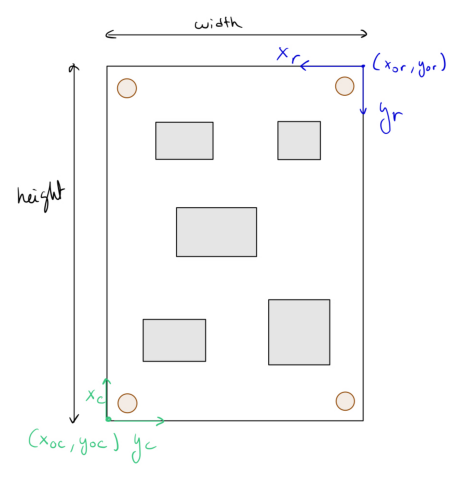

In [13]:
# Print the coordinates_system_computation.jpeg
image_coordinates = cv2.imread('maps/coordinates_system_computation.jpeg')

# Display without axis
plt.figure(figsize=(8,6))
plt.imshow(image_coordinates)
plt.axis('off')
plt.show()

### Modular and Versatile Functionality

Throughout the implementation, the vision system was designed to be modular and adaptable to different visualization and real-time processing modes. By including parameters and modes that can be adjusted, the system can be tailored for various use cases and can be easily integrated with other sub-systems within the robot's architecture.

## References
[20] soumibardhan10, *Convert BGR and RGB with Python – OpenCV*, https://www.geeksforgeeks.org/convert-bgr-and-rgb-with-python-opencv/ \
[21] Sylvain Paris – MIT CSAIL, *A Gentle Introduction to Bilateral Filtering and its Applications*, https://people.csail.mit.edu/sparis/bf_course/slides/03_definition_bf. \
[22] *OpenCV : Contours : Getting started. (s. d.).*, https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html